In [5]:
import streamlit as st
import pandas as pd
import pickle
import requests
import json
import joblib
import numpy as np
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
import folium
from streamlit_folium import st_folium
import plotly.express as px
import missingno as msno
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV,RepeatedStratifiedKFold,train_test_split
from sklearn.metrics import precision_score,confusion_matrix
from sklearn import tree
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
df=pd.read_csv("rüzgar.csv")
print(df.info())
print(df.columns)
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Time                 43800 non-null  object 
 1   temperature_2m       43800 non-null  float64
 2   relativehumidity_2m  43800 non-null  int64  
 3   dewpoint_2m          43800 non-null  float64
 4   windspeed_10m        43800 non-null  float64
 5   windspeed_100m       43800 non-null  float64
 6   winddirection_10m    43800 non-null  int64  
 7   winddirection_100m   43800 non-null  int64  
 8   windgusts_10m        43800 non-null  float64
 9   Power                43800 non-null  float64
dtypes: float64(6), int64(3), object(1)
memory usage: 3.3+ MB
None
Index(['Time', 'temperature_2m', 'relativehumidity_2m', 'dewpoint_2m',
       'windspeed_10m', 'windspeed_100m', 'winddirection_10m',
       'winddirection_100m', 'windgusts_10m', 'Power'],
      dtype='object')


,count,mean,std,min,25%,50%,75%,max
temperature_2m,43800.0,47.862911,19.453691,-14.4,32.1000,47.30000,64.5000,94.1000
relativehumidity_2m,43800.0,72.288744,16.852287,18.0,60.0000,74.00000,86.0000,100.0000
dewpoint_2m,43800.0,38.569308,18.772110,-17.1,24.3000,38.10000,54.7000,76.3000
windspeed_10m,43800.0,3.591147,1.649318,0.0,2.4100,3.30000,4.5900,13.4500
windspeed_100m,43800.0,6.284431,2.685216,0.1,4.3800,6.08000,7.9900,20.6500
winddirection_10m,43800.0,203.637329,96.371262,1.0,132.0000,225.00000,277.0000,360.0000
winddirection_100m,43800.0,203.343676,97.959852,0.0,130.0000,226.00000,278.0000,360.0000
windgusts_10m,43800.0,7.771795,3.569147,0.5,5.0000,7.20000,10.0000,29.2000
Power,43800.0,0.405385,0.288322,0.0,0.1489,0.34765,0.6596,0.9913


In [15]:
df.isnull().sum()

Time                   0
temperature_2m         0
relativehumidity_2m    0
dewpoint_2m            0
windspeed_10m          0
windspeed_100m         0
winddirection_10m      0
winddirection_100m     0
windgusts_10m          0
Power                  0
dtype: int64

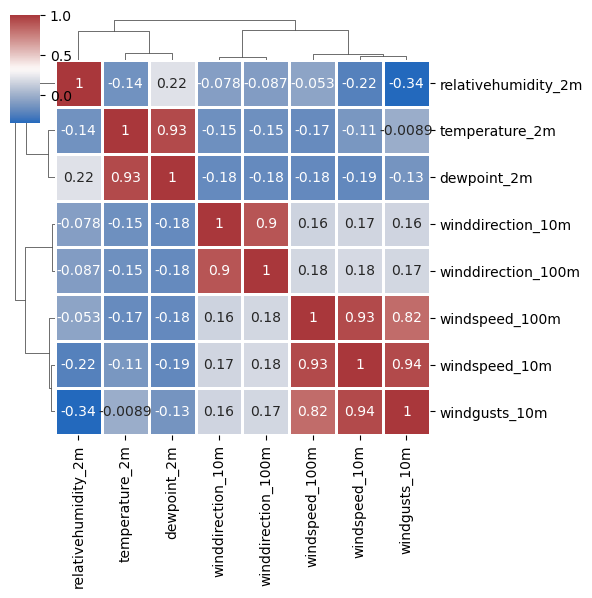

In [41]:
Y=df["Power"]
y_df=df.drop(["Time","Power"],axis=1)
sns.clustermap(y_df.corr(), cmap="vlag",dendrogram_ratio=(0.1,0.1), annot=True,linewidths=0.8,figsize=(6,6))
plt.show()

In [42]:
y_df.isnull().sum()

temperature_2m         0
relativehumidity_2m    0
dewpoint_2m            0
windspeed_10m          0
windspeed_100m         0
winddirection_10m      0
winddirection_100m     0
windgusts_10m          0
dtype: int64

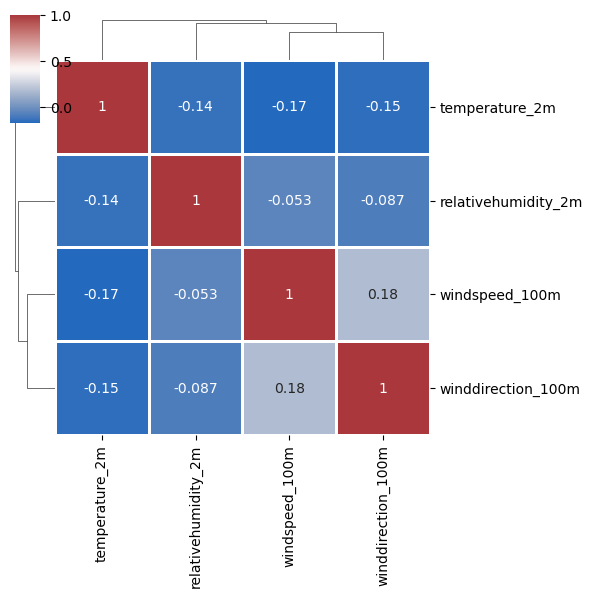

In [43]:
y_df=y_df.drop(["winddirection_10m","windgusts_10m","dewpoint_2m","windspeed_10m"],axis=1)
y_df.isnull().sum()
sns.clustermap(y_df.corr(), cmap="vlag",dendrogram_ratio=(0.1,0.1), annot=True,linewidths=0.8,figsize=(6,6))
plt.show()

<Figure size 1000x600 with 0 Axes>

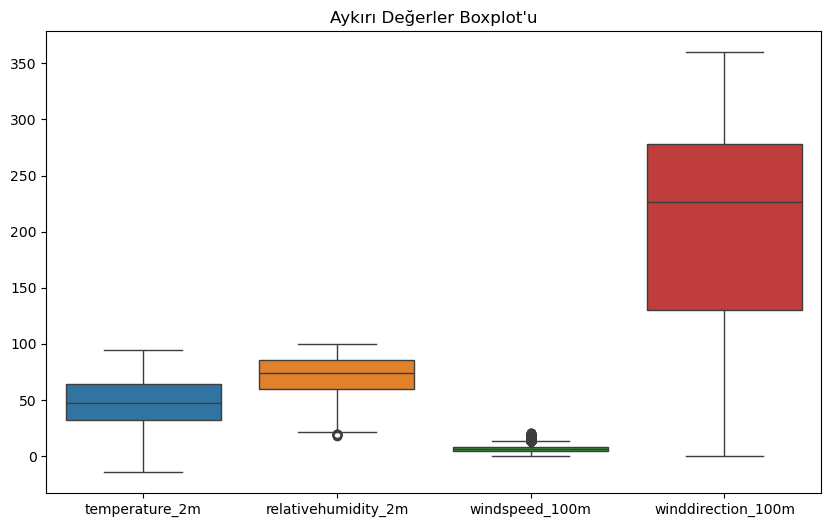

In [45]:
#görselleştirme
# Aykırı değerler için Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=y_df)
plt.title("Aykırı Değerler Boxplot'u")
plt.show()

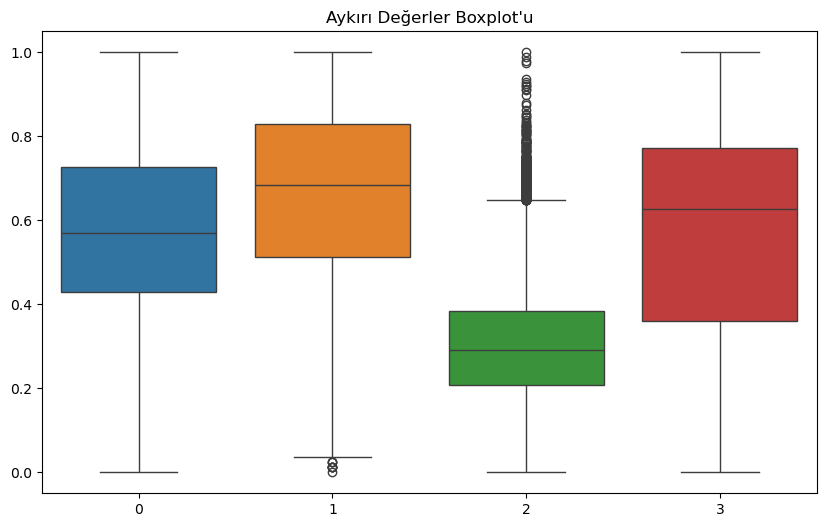

In [49]:
#standartize ettikten sonra daha iyi görünüyo
from sklearn import preprocessing
scaler=preprocessing.MinMaxScaler(feature_range=(0,1))
y_df=scaler.fit_transform(y_df)

# Aykırı değerler için plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=y_df)
plt.title("Aykırı Değerler Boxplot'u")
plt.show()

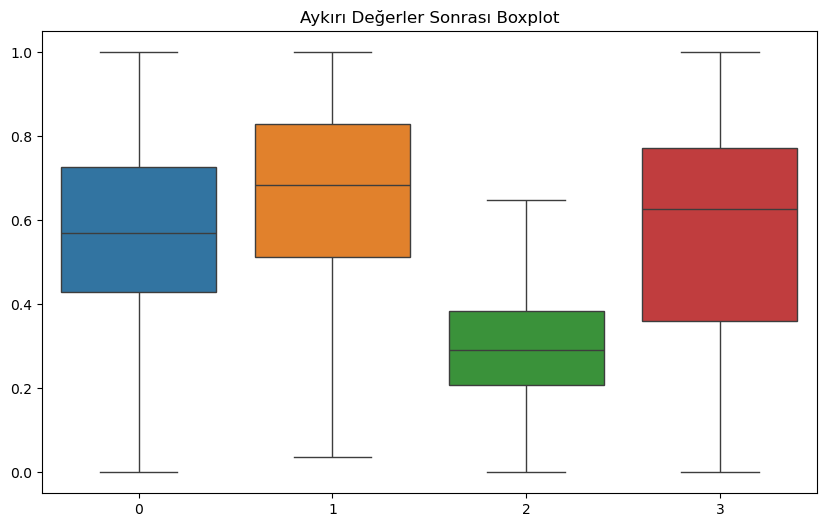

In [51]:
# IQR ile aykırı değerleri clip etme
Q1 = np.percentile(y_df, 25,axis=0)
Q3 = np.percentile(y_df, 75,axis=0)
IQR = Q3 - Q1

# Aykırı değerleri clip etme
x_clipped = np.clip(y_df, Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
# Clip edilmiş verinin Boxplot'u
plt.figure(figsize=(10, 6))
sns.boxplot(data=x_clipped)
plt.title("Aykırı Değerler Sonrası Boxplot")
plt.show()

In [52]:
X=x_clipped
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=42)
from sklearn import preprocessing
scaler=preprocessing.MinMaxScaler(feature_range=(0,1))
x_train=scaler.fit_transform(X_train)
x_test= scaler.transform(X_test)
x_test

array([[0.40552995, 0.64556962, 0.44419391, 0.13055556],
       [0.42119816, 0.74683544, 0.21871477, 0.01666667],
       [0.42304147, 0.64556962, 0.41939121, 0.07222222],
       ...,
       [0.77511521, 0.93670886, 0.38030815, 0.85      ],
       [0.47926267, 0.89873418, 0.29537768, 0.73055556],
       [0.48110599, 0.51898734, 0.24502067, 0.91666667]])

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Model: lr
Best Parameters: {'fit_intercept': True}
Best MSE: -0.0313510110626364
R² Score: 0.6210780161861817

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Model: Ridge
Best Parameters: {'alpha': 0.1, 'solver': 'auto'}
Best MSE: -0.03135101108358539
R² Score: 0.6210784575187132

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Model: Lasso
Best Parameters: {'alpha': 0.1}
Best MSE: -0.0831895888511511
R² Score: -4.77390194875138e-05

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Model: SVR
Best Parameters: {'C': 10, 'kernel': 'rbf'}
Best MSE: -0.025916655393593436
R² Score: 0.682811066377226

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Model: RF
Best Parameters: {'max_depth': 20, 'n_estimators': 300}
Best MSE: -0.025440392343697205
R² Score: 0.6938338107218986

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Model: GBM
Best Parameters: {'learning_rate': 0.05, 

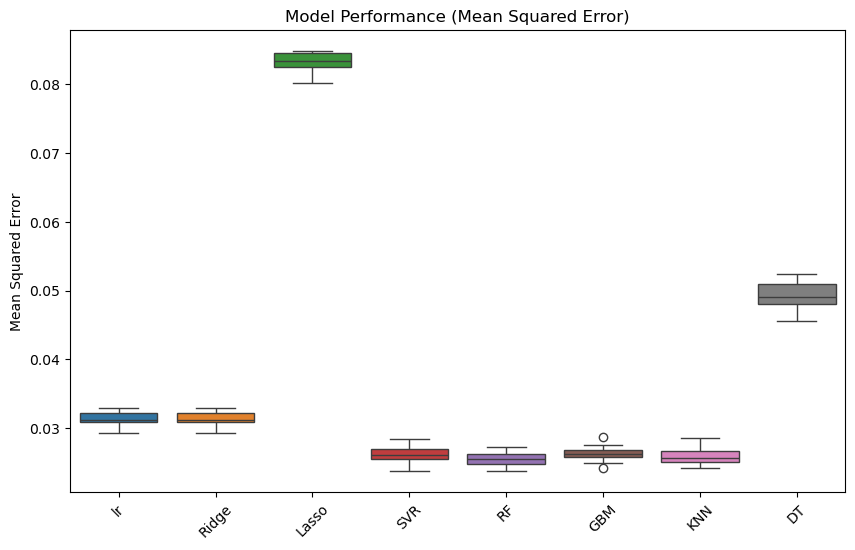

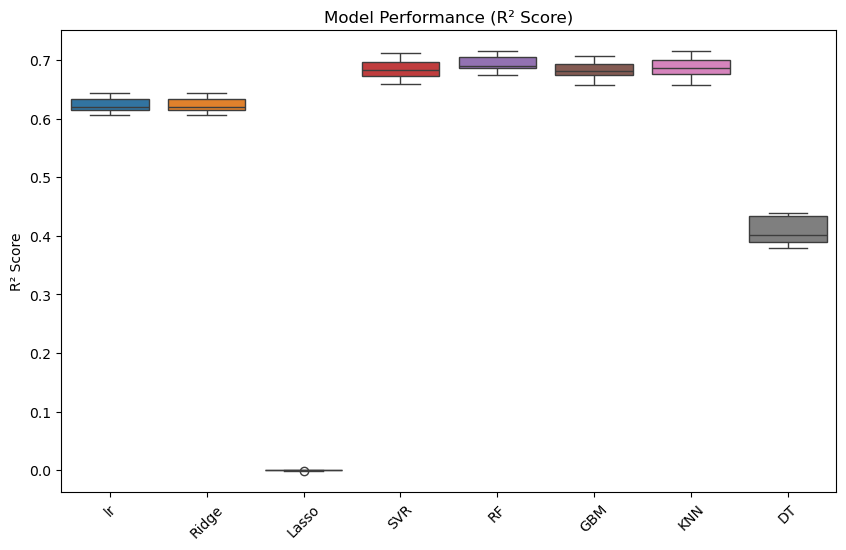

ValueError: too many values to unpack (expected 4)

In [54]:
#reg için best
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

def getmodels():
    models = []
    models.append(("lr", LinearRegression()))
    models.append(("Ridge", Ridge()))
    models.append(("Lasso", Lasso()))
    models.append(("SVR", SVR()))
    models.append(("RF", RandomForestRegressor()))
    models.append(("GBM", GradientBoostingRegressor()))
    models.append(("KNN", KNeighborsRegressor()))
    models.append(("DT", DecisionTreeRegressor()))
    return models

from sklearn.metrics import r2_score

def grid_search_regression(models, x_train, y_train):
    best_models = []
    
    for name, model in models:
        if name == "lr":
            param_grid = {'fit_intercept': [True, False]}
        elif name == "Ridge":
            param_grid = {'alpha': [0.1, 1, 10], 'solver': ['auto', 'svd', 'cholesky']}
        elif name == "Lasso":
            param_grid = {'alpha': [0.1, 1, 10]}
        elif name == "SVR":
            param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
        elif name == "RF":
            param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, None]}
        elif name == "GBM":
            param_grid = {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5, 7]}
        elif name == "KNN":
            param_grid = {'n_neighbors': [3, 5, 7, 10], 'metric': ['euclidean', 'manhattan']}
        elif name == "DT":
            param_grid = {'max_depth': [3, 5, 7, 10], 'min_samples_split': [2, 5, 10]}

        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
        grid_search.fit(x_train, y_train)

        # En iyi modelin test setinde performansını ölç
        y_pred = grid_search.best_estimator_.predict(x_test)
        r2 = r2_score(y_test, y_pred)

        print(f"Model: {name}")
        print(f"Best Parameters: {grid_search.best_params_}")
        print(f"Best MSE: {grid_search.best_score_}")
        print(f"R² Score: {r2}\n")

        best_models.append((name, grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_, r2))
    
    return best_models


def modelstrain(x_train, y_train, models):
    results = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=10)
        mse_scores = cross_val_score(model, x_train, y_train, cv=kfold, scoring="neg_mean_squared_error")
        r2_scores = cross_val_score(model, x_train, y_train, cv=kfold, scoring="r2")
        
        results.append(mse_scores)
        names.append(name)
        print(f"{name}: MSE: {-mse_scores.mean()}, std: {mse_scores.std()}, R²: {r2_scores.mean()}")

    return names, results


def plot_box(names, results):
    df = pd.DataFrame({names[i]: -results[i] for i in range(len(names))})
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df)
    plt.title("Model Performance (Mean Squared Error)")
    plt.ylabel("Mean Squared Error")
    plt.xticks(rotation=45)
    plt.show()

def plot_r2_box(names, r2_results):
    df = pd.DataFrame({names[i]: r2_results[i] for i in range(len(names))})
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df)
    plt.title("Model Performance (R² Score)")
    plt.ylabel("R² Score")
    plt.xticks(rotation=45)
    plt.show()


# Modelleri ve isimleri al
models = getmodels()

# Model parametreleriyle GridSearchCV işlemi
# Bu adımı sadece eğitimi önce yapıp, en iyi modelleri bulmak için çağırabilirsiniz.
best_models = grid_search_regression(models, x_train, y_train)

# En iyi model parametrelerini belirle
best_models = grid_search_regression(models, x_train, y_train)


# Model eğitimi ve değerlendirmesi
names, results = modelstrain(x_train, y_train, models)
# Boxplot görsellemesi
plot_box(names, results)

r2_results = [cross_val_score(model, x_train, y_train, cv=10, scoring="r2") for _, model in models]
plot_r2_box(names, r2_results)


# En iyi modelleri yazdır
for name, model, best_params, best_score in best_models:
    print(f"Best Model: {name}")
    print(f"Best Parameters: {best_params}")
    print(f"Best MSE: {best_score}\n")


In [55]:
import pickle
from sklearn.ensemble import RandomForestRegressor

best_model = RandomForestRegressor(max_depth=20, n_estimators=300)

best_model.fit(x_train, y_train)


with open("best_ruzgar_model.pkl", "wb") as model_file:
    pickle.dump(best_model, model_file)

print("Model başarıyla kaydedildi!")

Model başarıyla kaydedildi!


In [56]:
with open("best_ruzgar_model.pkl", "rb") as model_file:
    loaded_model = pickle.load(model_file)

predictions = loaded_model.predict(x_test)


from sklearn.metrics import r2_score, mean_squared_error

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Test MSE: {mse}")
print(f"Test R² Score: {r2}")


Test MSE: 0.02542864948101993
Test R² Score: 0.6936035247661234
